In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-3b1def15-1f21-5622-ac8e-57509b6b0cf0
device="cuda:0"
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
from IPython.display import HTML
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop, RandomCrop
from tft.mdct import mdct2d, inverse_mdct2d
from tft.utils import compand, decompand
from timm.models.efficientvit_mit import GELUTanh, EfficientVitBlock, ResidualBlock, build_local_block

dataset = datasets.load_dataset("danjacobellis/LSDIR")

env: CUDA_VISIBLE_DEVICES=MIG-3b1def15-1f21-5622-ac8e-57509b6b0cf0


Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/178 [00:00<?, ?it/s]

In [2]:
class PerChannelNoiseScale(nn.Module):
    def __init__(self, num_channels, total_scale):
        super().__init__()
        self.num_channels = num_channels
        self.alpha = nn.Parameter(torch.zeros(num_channels))
        self.min_scale = 1.0
        self.total_scale = total_scale

    def forward(self):
        exp_alpha = torch.exp(self.alpha)
        alpha_sum = exp_alpha.sum()
        total_excess = (self.total_scale - self.min_scale) * self.num_channels
        S_prime = total_excess * (exp_alpha / alpha_sum)
        return self.min_scale + S_prime

class NoiseInjectionModel(nn.Module):
    def __init__(self, num_channels, total_scale):
        super().__init__()
        self.num_channels = num_channels
        self.noise_scales = PerChannelNoiseScale(num_channels, total_scale)
        self.hardtanh = nn.Hardtanh(min_val=-127.49, max_val=127.49)

    def forward(self, x):
        if self.training:
            S = self.noise_scales()
            S_half = (S / 2.0).view(1, -1, 1, 1)
            noise = (torch.rand_like(x) * 2.0 - 1.0) * S_half
            x = x + noise
            x = self.hardtanh(x)
            return x
        else:
            S = self.noise_scales() 
            S_view = S.view(1, -1, 1, 1)
            x = self.hardtanh(x)
            x = x / S_view
            x = torch.round(x)
            return x

    def scale(self, x_int):
        S = self.noise_scales()
        S_view = S.view(1, -1, 1, 1)
        x_float = x_int * S_view
        x_float = self.hardtanh(x_float)
        return x_float


class GroupNorm8(torch.nn.Module):
    def __init__(self, num_features, eps=1e-7, affine=True):
        super().__init__()
        self.groupnorm = torch.nn.GroupNorm(num_groups=8,
                                      num_channels=num_features,
                                      eps=eps,
                                      affine=affine)
    def forward(self, x):
        return self.groupnorm(x)

class EfficientVitStageNoDS(nn.Module):
    def __init__(self, in_chs, out_chs, depth, norm_layer, act_layer):
        super(EfficientVitStageNoDS, self).__init__()
        blocks = [
            ResidualBlock(
                build_local_block(
                    in_channels=in_chs,
                    out_channels=out_chs,
                    stride=1,
                    expand_ratio=6,
                    norm_layer=norm_layer,
                    act_layer=act_layer,
                    fewer_norm=True,
                    block_type='default'
                ),
                None,
            )
        ]
        in_chs = out_chs
        for _ in range(depth):
            blocks.append(
                EfficientVitBlock(
                    in_channels=in_chs,
                    head_dim=32,
                    expand_ratio=6,
                    norm_layer=norm_layer,
                    act_layer=act_layer,
                )
            )
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)
        
def entropy_code(ints):
    webp_bytes = []
    for sample in ints:
        c_groups = sample.shape[0] // 3
        sample_webp = []
        for g in range(c_groups):
            group = sample[g*3 : g*3+3]
            group = (group + 127).clamp_(0, 255).byte()
            img = ToPILImage()(group)
            buff = io.BytesIO()
            img.save(buff, format='WEBP', lossless=True)
            sample_webp.append(buff.getbuffer())
        webp_bytes.append(sample_webp)
    
    return webp_bytes


def entropy_decode(webp_bytes):
    batch_out = []
    for sample_buffers in webp_bytes:
        group_tensors = []
        for buff in sample_buffers:
            with io.BytesIO(buff) as memfile:
                img = PIL.Image.open(memfile).convert('RGB')
            t = PILToTensor()(img).to(torch.int16) - 127
            group_tensors.append(t)
        sample_tensor = torch.cat(group_tensors, dim=0)
        sample_tensor = sample_tensor.unsqueeze(0)
        batch_out.append(sample_tensor)
    decoded = torch.cat(batch_out, dim=0)
    return decoded

In [3]:
class BottleneckNoiseModel(nn.Module):
    def __init__(self, in_channels, latent_channels, groups, total_scale):
        super().__init__()
        self.conv_down = nn.Conv2d(in_channels, latent_channels, kernel_size=1, padding=0, bias=False, groups=groups)
        self.noise_injection = NoiseInjectionModel(latent_channels, total_scale=total_scale)
        self.conv_up = nn.Conv2d(latent_channels, in_channels, kernel_size=1, padding=0, bias=False, groups=groups)
        self.vit =  EfficientVitStageNoDS(
            in_chs = in_channels,
            out_chs = in_channels,
            depth = 6,
            norm_layer=GroupNorm8,
            act_layer=GELUTanh,
        )

    def forward(self, x):
        x = self.conv_down(x)
        x = self.noise_injection(x)
        x = self.conv_up(x)
        x = self.vit(x)
        return x

    def scale(self, x_int):
        x_float = self.noise_injection.scale(x_int)
        x_float = self.conv_up(x_float)
        x_float = self.vit(x_float)
        return x_float

In [4]:
config = SimpleNamespace()
config.F = 12
config.excess_noise = 1;
config.latent_channels = 108; assert config.latent_channels%3 == 0
config.groups = 1
config.channels = int(3*config.F*config.F)
config.max_lr = 1e-3
config.min_lr = config.max_lr / 1e3
config.lr_pow = 6
config.img_size = 128
config.batch_size = 64
config.num_workers = 32
config.epochs = 48
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)

In [5]:
model = BottleneckNoiseModel(
    in_channels=config.channels,
    latent_channels=config.latent_channels,
    groups=config.groups,
    total_scale=1+config.excess_noise
).to(device)

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

21.798828 M parameters


In [6]:
def collate_fn(batch):
    return torch.cat([
        PILToTensor()(
            RandomCrop(
                config.img_size + 2*config.F,
                padding=config.F,
                padding_mode='reflect'
            )(sample['image'])
        ).unsqueeze(0) for sample in batch
    ]).to(torch.float)/127.5 - 1.0

In [7]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=collate_fn
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)

        X = compand(mdct2d(x, 2*config.F, 2*config.F))/40
    
        inputs = einops.rearrange(256*X, 'b c h w u v -> b (u v c) h w')
        outputs = einops.rearrange(
            model(inputs),
            'b (u v c) h w -> b c h w u v',
            u=X.shape[4],
            v=X.shape[5]
        )/256
        
        x_hat = inverse_mdct2d(decompand(40*outputs)).clamp(-1,1)
     
        loss = torch.nn.functional.mse_loss(
            CenterCrop(config.img_size)(x),
            CenterCrop(config.img_size)(x_hat)
        )
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
    
        pb.comment = f"PSNR: {-10*loss.log10().item()+6.02:.3g}, LR: {learning_rates[-1]:.3g}"

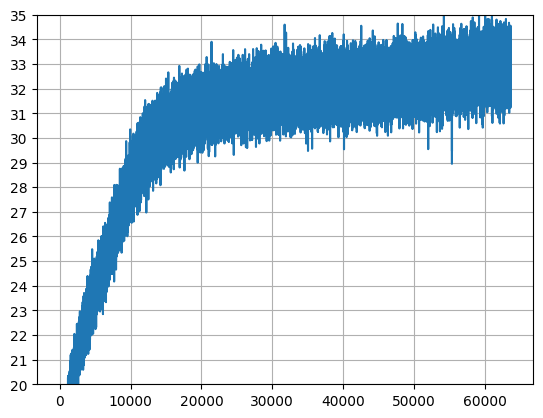

In [8]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
plt.plot(-10*np.log10(losses)+6.02)
plt.yticks(range(20,36));
plt.ylim([20,35])
plt.grid()

149.384 KB
5.264499544797301x compression ratio
3.938224866294093x dimension reduction
30.494360942840576 dB PSNR


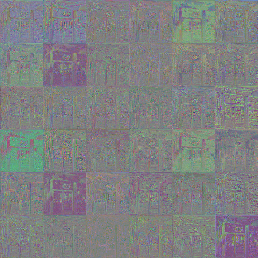

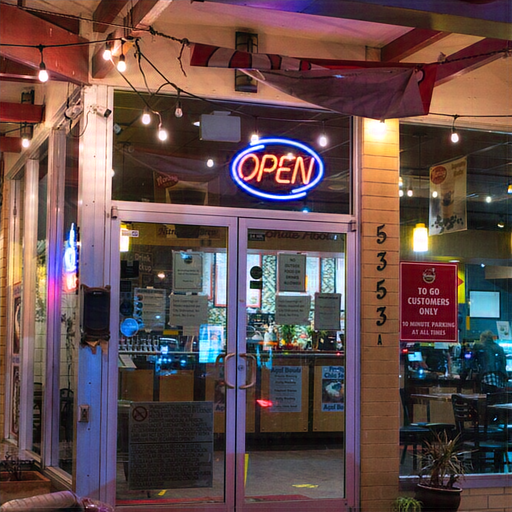

In [9]:
from walloc.walloc import latent_to_pil, pil_to_latent
model.eval()
config.img_size=512
img = CenterCrop(config.img_size)(dataset['validation'][28]['image'])
x = PILToTensor()(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
x_orig = x[0]
orig_dim = x.numel()
x = CenterCrop(config.img_size+2*config.F)(x)
X = compand(mdct2d(x, 2*config.F, 2*config.F))/40
inputs = einops.rearrange(256*X, 'b c h w u v -> b (u v c) h w')
with torch.no_grad():
    latent = model.noise_injection(model.conv_down(inputs))
webp = latent_to_pil(latent.cpu(),n_bits=8, C=3)
buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer())
print(f"{size_bytes/1e3} KB")
print(f"{orig_dim/size_bytes}x compression ratio")
print(f"{orig_dim/latent.numel()}x dimension reduction")
latent_decoded = pil_to_latent(webp, N=config.latent_channels, n_bits=8, C=3).to(device)
with torch.no_grad():
    outputs = model.scale(latent_decoded)
outputs = einops.rearrange(
    outputs,
    'b (u v c) h w -> b c h w u v',
    u=X.shape[4],
    v=X.shape[5]
)/256
x_hat = inverse_mdct2d(decompand(40*outputs))
x_hat = CenterCrop(config.img_size)(x_hat.clamp(-1,1))
mse = torch.nn.functional.mse_loss(
    CenterCrop(config.img_size)(x),
    x_hat
)
PSNR = -10*mse.log10().item() + 6.02
print(f"{PSNR} dB PSNR")

display(webp[0])
ToPILImage()(x_hat[0]/2+0.5)

(107.0, 147.0)

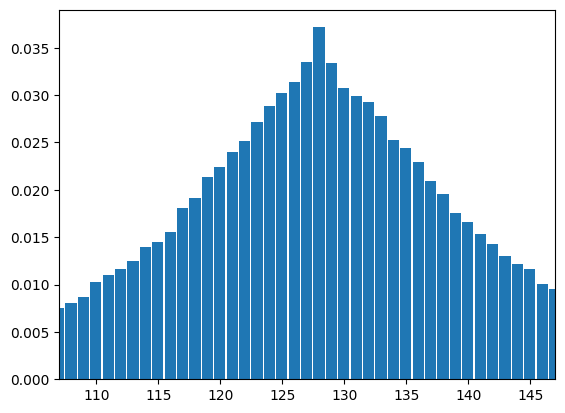

In [10]:
plt.hist(np.array(webp[0]).flatten(),bins=256,range=(-0.5,255.5),width=0.9,density=True);
plt.xlim([127-20,127+20])

6.5129217563625605


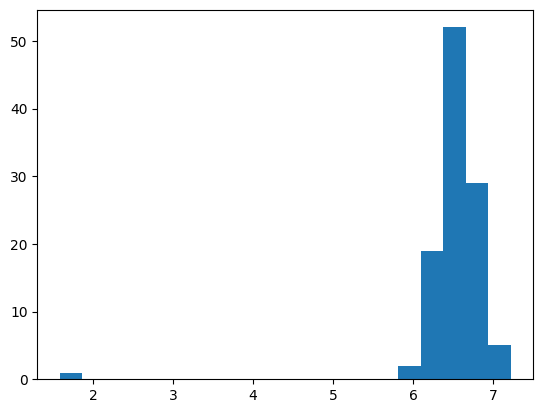

In [11]:
channel_bits = [np.log2(latent[0,i].unique().numel()) for i in range(config.latent_channels)]
plt.hist(channel_bits,bins=20);
print(np.mean(channel_bits))

30.899681091308594 PSNR
64K	test.jpg


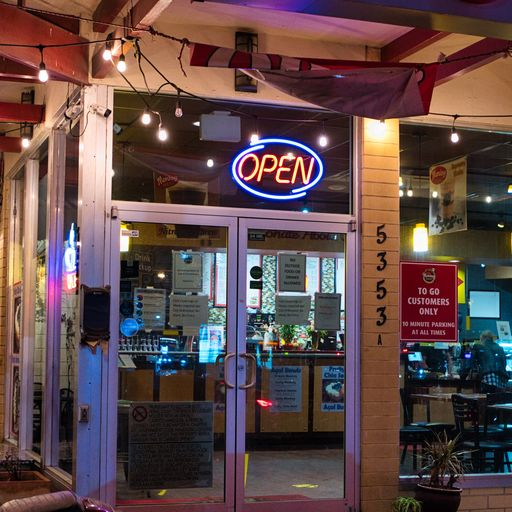

In [18]:
img.crop((0,0,config.img_size,config.img_size)).save("test.jpg",quality=80)
jpeg = PIL.Image.open("test.jpg")
MSE = torch.nn.functional.mse_loss(PILToTensor()(jpeg).to(torch.float)/255, x_orig.to("cpu")/2 + 0.5)
print(f"{-10*MSE.log10()} PSNR")
!du -sh test.jpg
display(jpeg)